In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install scikit-multilearn

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.layers import TextVectorization, LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Read data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project/jigsaw-toxic-comment-classification-challenge/train.csv')

In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
MAX_WORDS = 200000
vectorizer = TextVectorization(max_tokens = MAX_WORDS,
                               output_sequence_length = 1800,
                               output_mode = 'int')
vectorizer.adapt(X.values)
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [ ]:
vectorizer_text = vectorizer(X.values)
vectorizer_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorizer_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/project/toxicity.h5')
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
# Input sentence
input_sentence = "You freaking suck! I am going to hit you."
input_text = vectorizer(input_sentence)

In [ ]:
# Vectorize the input text
MAX_SEQUENCE_LENGTH = 1800

# Reshape input to match model's expected input shape
input_text_vectorized = tf.reshape(input_text, (-1, MAX_SEQUENCE_LENGTH))

# Predict
res = model.predict(input_text_vectorized)
#res = model.predict(input_text)

1/1 [==============================] - 2s 2s/step


In [ ]:
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)
res.shape

1/1 [==============================] - 0s 284ms/step


(1, 6)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    rec.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [ ]:
Precision_dl = pre.result().numpy()
Recall_dl = rec.result().numpy()
Accuracy_dl = acc.result().numpy()
# Calculate F1 score
F1_dl = 2 * (Precision_dl * Recall_dl) / (Precision_dl + Recall_dl)
print(f'F1-score: {F1_dl}')
print(f'Precision: {pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

F1-score: 0.8457269458698331
Precision: 0.8602879047393799, Recall:0.8316507339477539, Accuracy:0.5215647220611572


In [ ]:
#input_str = vectorizer(input_sentence)
dl_predictions = model.predict(np.expand_dims(input_text,0))
dl_predictions

1/1 [==============================] - 0s 439ms/step


array([[0.9996516 , 0.5181806 , 0.9736962 , 0.07476531, 0.9257783 ,
        0.37551802]], dtype=float32)

In [ ]:
(dl_predictions > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)
dl_predictions.shape

# Display the predicted probabilities for Model 1
print("Predicted probabilities for Model 1 (Deep Learning model with LSTM Layer):")
for i, label in enumerate(df.columns[2:]):
    print(f"{label}: {dl_predictions[0, i]}")

1/1 [==============================] - 0s 454ms/step
Predicted probabilities for Model 1 (Deep Learning model with LSTM Layer):
toxic: 0.9996516108512878
severe_toxic: 0.5181806087493896
obscene: 0.9736961722373962
threat: 0.07476530969142914
insult: 0.925778329372406
identity_hate: 0.3755180239677429


In [ ]:
import re

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub('\n', ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\"+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

df['clean_text'] = df['comment_text'].apply(clean_text)

# Process text
stop_words = set(stopwords.words('english'))

def process_text(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

processed_data = list(map(process_text, df['clean_text']))

In [ ]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [ ]:
X_lem = lemmatized_output
y_lem = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=15)

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_data_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_data_test = tfidf_vectorizer.transform(X_test)

# Model 2: Naive Bayes Model with TF-IDF Vectorization
classifier = BinaryRelevance(classifier=MultinomialNB(), require_dense=[False, True])
classifier.fit(tfidf_data_train, y_train)
predictions = classifier.predict_proba(tfidf_data_test)

# Evaluate Model 2
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)
precision_nb = precision_score(y_test, binary_predictions, average='micro')
recall_nb = recall_score(y_test, binary_predictions, average='micro')
f1_nb = f1_score(y_test, binary_predictions, average='micro')

In [ ]:
# Clean and preprocess the input sentence (similar to preprocessing done for training data)
cleaned_input = clean_text(input_sentence)
processed_input = process_text(cleaned_input)
lemmatized_input = ' '.join([lemmatizer.lemmatize(w) for w in processed_input])

In [ ]:
# Convert the input sentence into TF-IDF vectors for Model 2
tfidf_input = tfidf_vectorizer.transform([lemmatized_input])

# Predict probabilities for Model 2 (Naive Bayes with TF-IDF)
nb_predictions = classifier.predict_proba(tfidf_input)

# Display the predicted probabilities for Model 2
print("Predicted probabilities for Model 2 (Naive Bayes with TF-IDF):")
for i, label in enumerate(y_train.columns):
    print(f"{label}: {nb_predictions[0, i]}")

Predicted probabilities for Model 2 (Naive Bayes with TF-IDF):
toxic: 0.753883171397431
severe_toxic: 0.045665796191816994
obscene: 0.477136154432957
threat: 0.004275410185283148
insult: 0.3046203888050856
identity_hate: 0.01434865524947094


In [ ]:
# Model comparison
print("Performance Metrics Comparison:")
print("Naive Bayes - Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(precision_nb, recall_nb, f1_nb))
print("Deep Learning - Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(Precision_dl, Recall_dl, F1_dl))

Performance Metrics Comparison:
Naive Bayes - Precision: 0.8902, Recall: 0.4699, F1-score: 0.6152
Deep Learning - Precision: 0.8603, Recall: 0.8317, F1-score: 0.8457


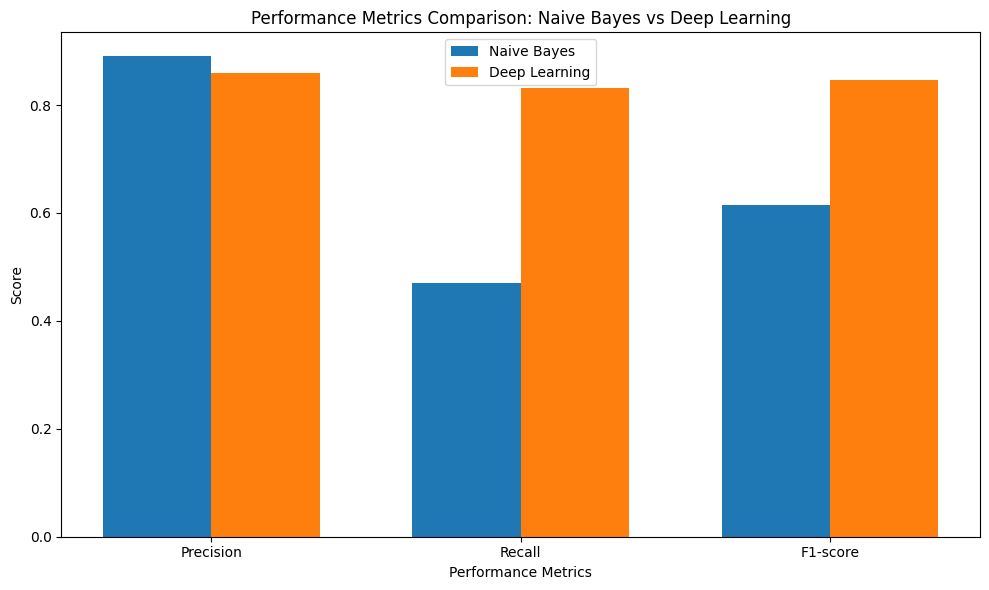

In [ ]:
import matplotlib.pyplot as plt

# Labels for the models
models = ['Naive Bayes', 'Deep Learning']

# Metrics to plot
metrics = ['Precision', 'Recall', 'F1-score']
nb_metrics = [precision_nb, recall_nb, f1_nb]
dl_metrics = [Precision_dl, Recall_dl, F1_dl]

# Plotting the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(metrics))  # Adjusted to use metrics instead of models

# Plotting bars for Naive Bayes
plt.bar(index, nb_metrics, bar_width, label='Naive Bayes')

# Plotting bars for Deep Learning
plt.bar([i + bar_width for i in index], dl_metrics, bar_width, label='Deep Learning')

# Adding labels and title
plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison: Naive Bayes vs Deep Learning')
plt.xticks([i + bar_width/2 for i in index], metrics)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()
